In [16]:

import pandas as pd

%matplotlib inline

In [17]:
%%time
from ams.config import constants
from pathlib import Path
from ams.services import file_services

senti_dataframes = []

folder_path_str = Path(constants.TWITTER_OUTPUT_RAW_PATH, "sent_drop", "staging")

file_paths = file_services.list_files(folder_path_str, ends_with=".parquet", use_dir_recursion=True)

Wall time: 2 ms


In [18]:
from ams.utils.date_utils import TZ_AMERICA_NEW_YORK, STANDARD_DAY_FORMAT
import pytz

def convert_to_date_string(utc_timestamp: int):
    dt_utc = datetime.fromtimestamp(utc_timestamp)
    dt_nyc = dt_utc.astimezone(pytz.timezone(TZ_AMERICA_NEW_YORK))
    return dt_nyc.strftime(STANDARD_DAY_FORMAT)

In [19]:
%%time

from ams.utils import date_utils
from datetime import datetime

twitter_format = date_utils.TWITTER_LONG_FORMAT 
    
def add_ts(date_string: str):
        result = None
        try:
            dt = datetime.strptime(date_string, twitter_format)
            result = int(dt.timestamp())
        except Exception as e:
            pass
        return result

def add_timestamp(df):
    print(f'Count: {df.shape[0]}')
        
    df = df[df['created_at'].notnull()]
    
    df["created_at_timestamp"] = df["created_at"].apply(add_ts)
    
    return df

Wall time: 1e+03 µs


In [20]:

def get_fave_cols(df):
    return df[["created_at",
                     "user_screen_name",
                     "favorite_count",
                     "in_reply_to_screen_name",
                     "user_verified",
                     "metadata_result_type",
                     "user_listed_count",
                     "user_time_zone",
                     "user_has_extended_profile",
                     "in_reply_to_status_id",
                     "user_statuses_count",
                     "user_protected",
                     "user_is_translation_enabled",
                     "user_location",
                     "lang",
                     "user_geo_enabled",
                     "place_country",
                     "place_name",
                     "possibly_sensitive",
                     "user_friends_count",
                     "retweet_count",
                     "user_follow_request_sent",
                     "user_followers_count",
                     "f22_ticker",
                     "f22_has_cashtag",
                     "f22_ticker_in_text",
                     "f22_num_other_tickers_in_tweet",
                     "f22_sentiment_pos",
                     "f22_sentiment_neu",
                     "f22_sentiment_neg",
                     "f22_sentiment_compound",
                     "f22_id"]]

In [21]:
from ams.services import  file_services
from pyspark.sql import DataFrame

tag = 'lpd'
parent_path = Path(constants.TWITTER_OUTPUT_RAW_PATH, 'learning_prep_drop')
sent_drop_path = file_services.create_unique_folder_name(parent_path, prefix=tag)

print(f"Drop path: '{sent_drop_path}'.")

def persist_parquet(df: DataFrame):
    file_path =  file_services.create_unique_filename(parent_dir=sent_drop_path, prefix="lpd", extension="parquet")
    file_path_str = str(file_path)
    df.to_parquet(file_path_str)

Drop path: C:\Users\Chris\workspaces\data\twitter\learning_prep_drop\lpd_2020-11-27_23-07-13-694.07.


In [22]:
%%time

def calc_compound_score(row):
    return row["user_followers_count"] * row["f22_sentiment_compound"]

samples = []
for f in file_paths:
    print(str(f))
    df = pd.read_parquet(f)
    
    print(f"{df.columns}")
    print(f"{df.shape}")
    
    df = get_fave_cols(df)
    
    df = add_timestamp(df)
       
    df = df[df['created_at_timestamp'].notnull()]
    
    df['date'] = df['created_at_timestamp'].apply(convert_to_date_string)
    
    df = df[df['user_followers_count'].notnull()]
    df = df[df['f22_sentiment_compound'].notnull()]
    
    df['user_followers_count'] = df['user_followers_count'].astype("int")
    df['f22_sentiment_compound'] = df['f22_sentiment_compound'].astype("float64")            
            
    df['f22_compound_score'] = df.apply(calc_compound_score, axis=1)
    
    df = df.drop_duplicates(subset=['f22_id'])
    
    persist_parquet(df=df)
    samples.append(df.sample(frac=.001))


C:\Users\Chris\workspaces\data\twitter\sent_drop\staging\sd_2020-11-27_22-18-57-741.92\part.0.parquet
Index(['entities_user_mentions_2', 'user_profile_background_image_url_https',
       'user_followers_count', 'user_created_at', 'user_default_profile_image',
       'user_name', 'user_profile_background_tile', 'metadata_result_type',
       'user_time_zone', 'user_follow_request_sent', 'entities_urls_0',
       'user_location', 'user_notifications', 'user_lang',
       'user_has_extended_profile', 'entities_urls_3', 'place_country',
       'user_description', 'user_protected', 'user_verified',
       'user_favourites_count', 'lang', 'user_contributors_enabled',
       'retweeted', 'source', 'user_url', 'id', 'user_profile_banner_url',
       'entities_user_mentions_0', 'user_listed_count', 'user_friends_count',
       'retweet_count', 'user_is_translator', 'user_id',
       'in_reply_to_screen_name', 'entities_urls_1',
       'user_is_translation_enabled', 'user_geo_enabled',
       'u

Count: 716135
C:\Users\Chris\workspaces\data\twitter\sent_drop\staging\sd_2020-11-27_22-18-57-741.92\part.12.parquet
Index(['entities_user_mentions_2', 'user_profile_background_image_url_https',
       'user_followers_count', 'user_created_at', 'user_default_profile_image',
       'user_name', 'user_profile_background_tile', 'metadata_result_type',
       'user_time_zone', 'user_follow_request_sent', 'entities_urls_0',
       'user_location', 'user_notifications', 'user_lang',
       'user_has_extended_profile', 'entities_urls_3', 'place_country',
       'user_description', 'user_protected', 'user_verified',
       'user_favourites_count', 'lang', 'user_contributors_enabled',
       'retweeted', 'source', 'user_url', 'id', 'user_profile_banner_url',
       'entities_user_mentions_0', 'user_listed_count', 'user_friends_count',
       'retweet_count', 'user_is_translator', 'user_id',
       'in_reply_to_screen_name', 'entities_urls_1',
       'user_is_translation_enabled', 'user_geo_enab

Count: 535299
C:\Users\Chris\workspaces\data\twitter\sent_drop\staging\sd_2020-11-27_22-18-57-741.92\part.3.parquet
Index(['entities_user_mentions_2', 'user_profile_background_image_url_https',
       'user_followers_count', 'user_created_at', 'user_default_profile_image',
       'user_name', 'user_profile_background_tile', 'metadata_result_type',
       'user_time_zone', 'user_follow_request_sent', 'entities_urls_0',
       'user_location', 'user_notifications', 'user_lang',
       'user_has_extended_profile', 'entities_urls_3', 'place_country',
       'user_description', 'user_protected', 'user_verified',
       'user_favourites_count', 'lang', 'user_contributors_enabled',
       'retweeted', 'source', 'user_url', 'id', 'user_profile_banner_url',
       'entities_user_mentions_0', 'user_listed_count', 'user_friends_count',
       'retweet_count', 'user_is_translator', 'user_id',
       'in_reply_to_screen_name', 'entities_urls_1',
       'user_is_translation_enabled', 'user_geo_enabl

Count: 595973
C:\Users\Chris\workspaces\data\twitter\sent_drop\staging\sd_2020-11-27_22-18-57-741.92\part.7.parquet
Index(['entities_user_mentions_2', 'user_profile_background_image_url_https',
       'user_followers_count', 'user_created_at', 'user_default_profile_image',
       'user_name', 'user_profile_background_tile', 'metadata_result_type',
       'user_time_zone', 'user_follow_request_sent', 'entities_urls_0',
       'user_location', 'user_notifications', 'user_lang',
       'user_has_extended_profile', 'entities_urls_3', 'place_country',
       'user_description', 'user_protected', 'user_verified',
       'user_favourites_count', 'lang', 'user_contributors_enabled',
       'retweeted', 'source', 'user_url', 'id', 'user_profile_banner_url',
       'entities_user_mentions_0', 'user_listed_count', 'user_friends_count',
       'retweet_count', 'user_is_translator', 'user_id',
       'in_reply_to_screen_name', 'entities_urls_1',
       'user_is_translation_enabled', 'user_geo_enabl

Wall time: 262 ms


<AxesSubplot:xlabel='date'>

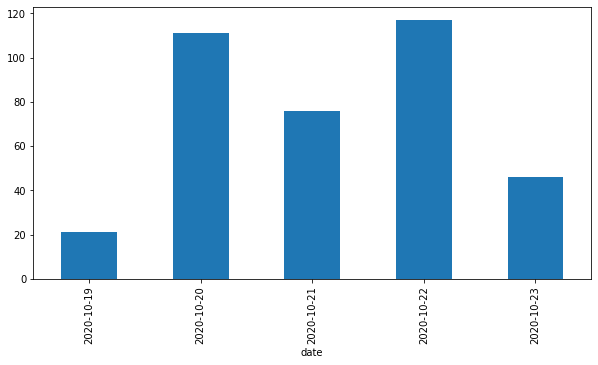

In [14]:
%%time 

df_combined = pd.concat(samples, axis=0)

df_combined.sort_values(by=['date'], inplace=True)

day_groups = df_combined.groupby(df_combined['date'])['date'].count()

day_groups.plot(kind='bar', figsize=(10,5), legend=None)